In [1]:
import math
import pandas as pd
import tqdm
import numpy as np

import torch
import torch.utils.data as data
import torch.optim as optim

from MINE import controller, datasets, losses, models

In [2]:
def experiment(batch_size=100):
    data_loader = data.DataLoader(
        datasets.IntegerPairDataset(
            number_of_cases=16,
            x_encoding='one_hot',
            y_encoding='one_hot',
            transform=datasets.TransformToTensor()
        ),
        batch_size=batch_size,
    )
    loss = losses.mine_loss()
    network = models.ConcatNet(16, 64)
    optimizer = optim.SGD(network.parameters(), lr=0.1)

    agent = controller.MINEController(
        data_loader=data_loader, loss=loss, network=network, optimizer=optimizer
    )
    
    agent.to(0)
    agent.train()
    for i in tqdm.tqdm(range(3000)):
        agent.step()

    return agent

In [3]:
agent = experiment()

100%|██████████| 3000/3000 [01:16<00:00, 39.27it/s]


In [5]:
def get_t(agent, batch_size=100):
    t = []
    for i in range(0, len(agent.history), batch_size):
        t.append(np.average(agent.history.joint_value[i:i+batch_size]))
    return np.array(t)

def get_et(agent, batch_size=100):
    et = []
    for i in range(0, len(agent.history), batch_size):
        et.append(np.log(np.average(np.exp(agent.history.marginal_value[i:i+batch_size]))))
    return np.array(et)

t = get_t(agent)
et = get_et(agent)
mi = t-et

In [164]:
import matplotlib
matplotlib.rc('font', size=16)

<IPython.core.display.Javascript object>


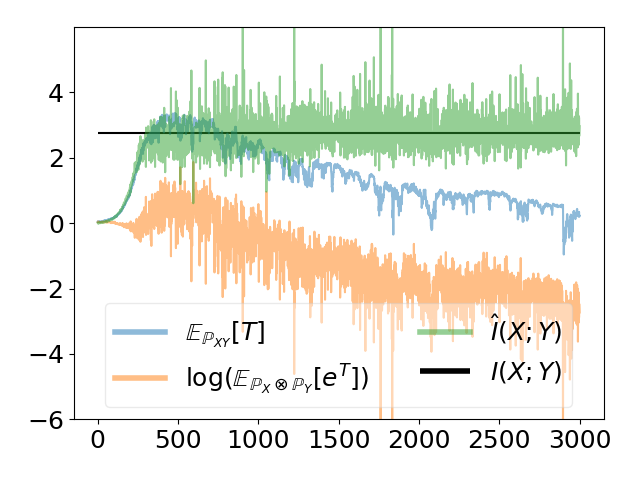

In [175]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(t, alpha=0.5, label='$\mathbb{E}_{\mathbb{P}_{X Y}}[T]$')
plt.plot(et, alpha=0.5, label='$\log(\mathbb{E}_{\mathbb{P}_X \otimes \mathbb{P}_Y}[e^{T}])$')
plt.plot(mi, alpha=0.5, label='$\hat{I}(X; Y)$')
plt.hlines(np.log(16), 0, 3000, label='$I(X;Y)$')
lg = plt.legend(loc='lower center', ncol=2, framealpha=0.4, fontsize='medium')
plt.setp(lg.get_lines(), linewidth=4)
plt.ylim(-6, 6)
plt.yticks([-6, -4, -2, 0, 2, 4])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


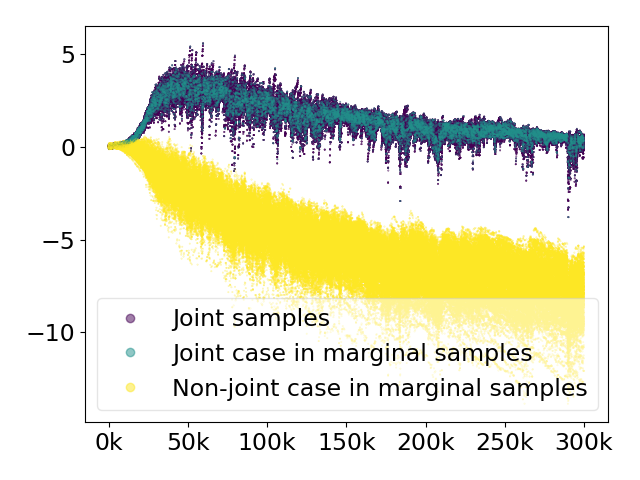

In [179]:
%matplotlib notebook
import matplotlib.pyplot as plt

matplotlib.rc('font', size=17)
plt.subplot(1, 1, 1)
sct = plt.scatter(
    list(range(len(agent.history))) + list(range(len(agent.history))),
    list(agent.history.joint_value) + list(agent.history.marginal_value),
    s=0.1, alpha=0.5,
    c=[1 for i in agent.history.is_joint_case] + [2 if i else 3 for i in agent.history.is_joint_case]
)

plt.xticks(list(range(0, 350000, 50000)), [f'{i*50}k' for i in range(7)])
plt.tight_layout()
plt.legend(
    sct.legend_elements()[0],
    ['Joint samples', 'Joint case in marginal samples', 'Non-joint case in marginal samples'],
    framealpha=0.5
)
plt.show()

<IPython.core.display.Javascript object>


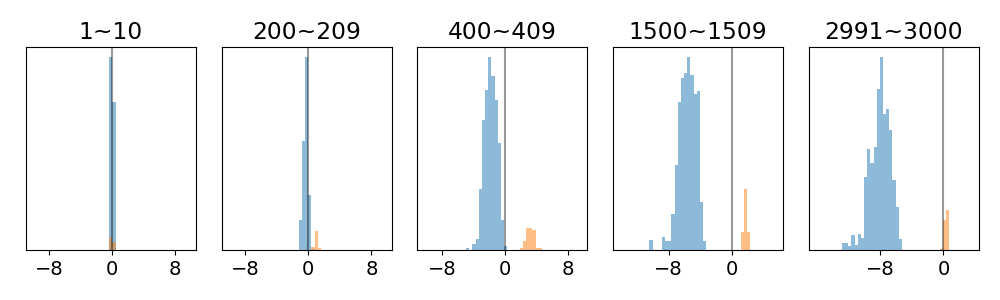

findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.


In [165]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', size=14)

plt.figure(figsize=(10, 3))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for i, start_iter in enumerate((0, 199, 399, 1499, 2990)):
    plt.subplot(1, 5, i+1)
    
    mid = (max(agent.history.marginal_value[start_iter*100:start_iter*100+1000]) + min(agent.history.marginal_value[start_iter*100:start_iter*100+1000]))/2
    plt.hist(
        agent.history[(agent.history.is_joint_case == 0) & (agent.history.index >= start_iter * 100) & (agent.history.index <  start_iter * 100 + 1000)].marginal_value,
        bins=np.arange(mid-10, mid+10, 0.4),
        alpha=0.5
    )
    plt.hist(
        agent.history[(agent.history.is_joint_case == 1) & (agent.history.index >= start_iter * 100) & (agent.history.index <  start_iter * 100 + 1000)].marginal_value,
        bins=np.arange(mid-10, mid+10, 0.4),
        alpha=0.5
    )
    plt.title(f'{start_iter+1}~{start_iter+10}')
    plt.axvline(0, color='black', alpha=0.4)

    plt.yticks([])
    if i < 3:
        plt.xticks([-8, 0, 8])
    else:
        plt.xticks([-8, 0])
    plt.tight_layout()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


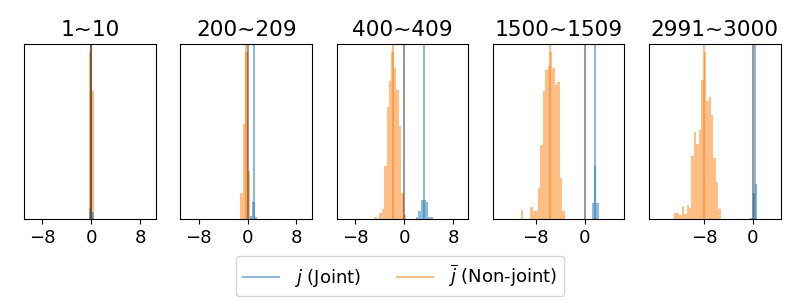

In [200]:
%matplotlib notebook
import matplotlib.pyplot as plt

matplotlib.rc('font', size=13)
plt.figure(figsize=(8, 3))
for i, start_iter in enumerate((0, 199, 399, 1499, 2990)):
    plt.subplot(1, 5, i+1)

    mid = (max(agent.history.marginal_value[start_iter*100:start_iter*100+1000]) + min(agent.history.marginal_value[start_iter*100:start_iter*100+1000]))/2
    njs = agent.history[(agent.history.is_joint_case == 0) & (agent.history.index >= start_iter * 100) & (agent.history.index <  start_iter * 100 + 1000)].marginal_value
    js = agent.history[(agent.history.is_joint_case == 1) & (agent.history.index >= start_iter * 100) & (agent.history.index <  start_iter * 100 + 1000)].marginal_value

    plt.axvline(np.average(js), color='C0', label='$j$ (Joint)' if i == 0 else None, alpha=0.5)
    plt.axvline(np.average(njs), color='C1', label='$\overline{j}$ (Non-joint)' if i == 0 else None, alpha=0.5)
    
    njs_hst = plt.hist(
        njs,
        bins=np.arange(mid-10, mid+10, 0.4),
        alpha=0.5,
        color='C1',
    )
    js_hst = plt.hist(
        js,
        bins=np.arange(mid-10, mid+10, 0.4),
        alpha=0.5,
        color='C0',
    )
    plt.axvline(0, color='black', alpha=0.4)
    
    plt.title(f'{start_iter+1}~{start_iter+10}')
    plt.yticks([])
    if i < 3:
        plt.xticks([-8, 0, 8])
    else:
        plt.xticks([-8, 0])
    plt.tight_layout()

plt.tight_layout()
plt.gcf().legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0.08))
plt.gcf().subplots_adjust(bottom=0.27)
plt.show()

In [7]:
mi_list = []
batch_sizes = (100, 200, 400, 800, )
for b in batch_sizes:
    agent_b = experiment(b)
    mi_list.append(get_t(agent_b, b)-get_et(agent_b, b))

100%|██████████| 3000/3000 [08:44<00:00,  5.72it/s]


<IPython.core.display.Javascript object>


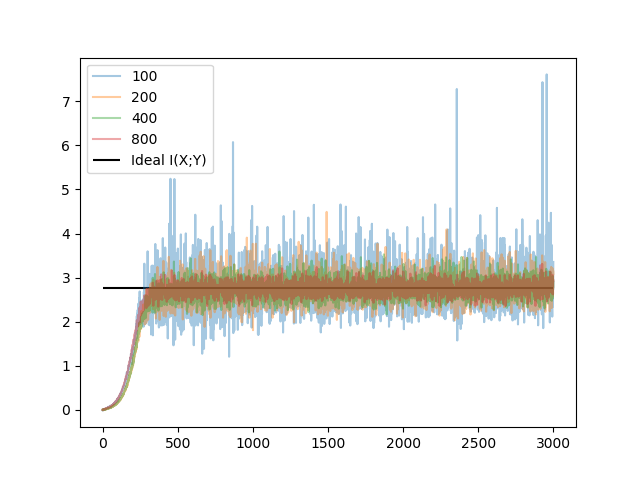

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

for index, b in enumerate(batch_sizes):
    plt.plot(mi_list[index], alpha=0.4, label=b)
plt.hlines(np.log(16), 0, 3000, label='Ideal I(X;Y)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


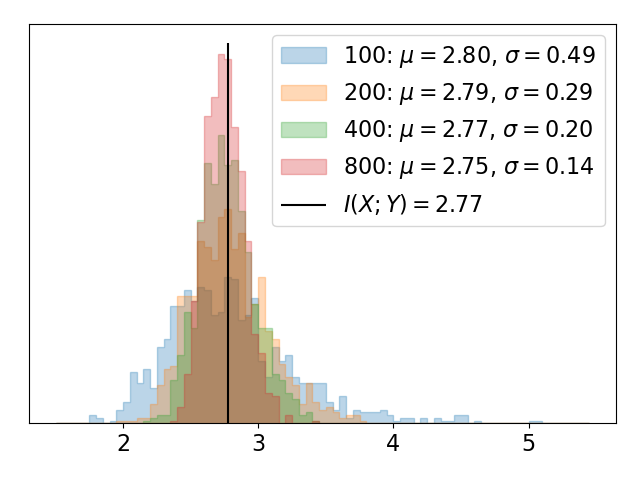

In [99]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

for index, b in enumerate(list(batch_sizes)[::]):
    d = mi_list[index][2000:]
    mu = np.mean(d)
    sigma = np.std(d)
    plt.hist(
        d,
        label=f'${b}$: $\mu={mu:.2f}$, $\sigma={sigma:.2f}$',
        bins=np.arange(1.5, 5.5, 0.05),
        fill=True,
        histtype='step',
        alpha=0.3,
    )
    plt.yticks([])

plt.vlines(math.log(16), 0, 140, label='$I(X;Y)=2.77$')
plt.legend()
plt.tight_layout()

plt.show()

In [94]:
math.log(16)

2.772588722239781